In [433]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.models import Sequential, Model
from keras.layers import InputLayer, Input, Masking
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [434]:
def plot_confusion_matrix(cm, labels_name, title): 
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Reds)   
    plt.title(title)       
    plt.colorbar()     
    plt.ylabel('True label')        
    plt.xlabel('Predicted label')
    indices = range(len(cm))
    plt.xticks(indices, ['T','F'])
    plt.yticks(indices, ['T','F'])
    plt.show()

In [435]:
def portfolio_generator1(principal,prediction,true_price, leverage = 1,short = True, transc = 0.109):

    n = true_price.shape[0]
    value_over_time = np.zeros(n) #portfolio value over time
    cash = np.zeros(n) #cash value over time
    units = np.zeros(n) #shares owned over time
    cash[0] = principal*leverage
    units[0] = 0.0
    borrow = np.ones(n)*principal*(leverage-1) #amount borrowed
    cond = 1

    for i in range(n):
        if short:
            #Entering position
            if cond == 1:
                if prediction[i] > 0.5:
                    if i != 0:
                        units[i] = (1-transc)*cash[i-1]/true_price[i]
                        cash[i] = 0
                        cond = 2
                    else:
                        units[i] = (1-transc)*cash[i]/true_price[i]
                        cash[i] = 0
                        cond = 2
                    #print('Enter Long from none')
                elif prediction[i] < 0.48:
                    if i != 0:
                        units[i] = -(1-transc)*cash[i-1]/true_price[i]
                        cash[i] = cash[i-1] - units[i]*true_price[i]
                        cond = 3
                    else:
                        units[i] = -(1-transc)*cash[i]/true_price[i]
                        cash[i] = cash[i] - units[i]*true_price[i]
                        cond = 3
                    #print('Enter Short from none')
                elif i == 0 and prediction[i] > 0.48 and prediction[i] < 0.5:
                    cond = 1
                else:
                    cash[i] = cash[i-1]
                    units[i] = units[i-1]
                    cond = 1
            #Exiting long position
            elif cond == 2 and prediction[i] < 0.5:
                #Exit long
                cash[i] = cash[i-1] + (1-transc)*units[i-1]*true_price[i]
                units[i] = 0
                #print('Exit long')
                #Enter Short
                units[i] = -(1-transc)*cash[i]/true_price[i]
                cash[i] = cash[i] - units[i]*true_price[i]
                cond = 3
                #print('Enter short from long')
            #Exiting short position
            elif cond == 3 and prediction[i] >0.48:
                #Exit short
                cash[i] = cash[i-1] + (1-transc)*units[i-1]*true_price[i]
                units[i] = 0
                #print('Exit Short')
                #Enter long
                units[i] = (1-transc)*cash[i]/true_price[i]
                cash[i] = 0
                cond = 2
                #print('Enter long from short')
            #Holding Condition
            else:
                cash[i] = cash[i-1]
                units[i] = units[i-1]
                #print('Holding')
        else:
            #Entering position
            if cond == 1 and prediction[i] > 0.48:
                units[i] = (1-transc)*cash[i]/true_price[i]
                cash[i] = 0
                cond = 2
                #print('Enter')
            #Exiting position
            elif cond == 2 and prediction[i] < 0.5:
                cash[i] = (1-transc)*true_price[i]*units[i-1]
                units[i] = 0
                cond = 1
                #print('Exit')
            #Holding Condition
            else:
                cash[i] = cash[i-1]
                units[i] = units[i-1]
                #print('Holding')

    value_over_time = cash + np.multiply(units,true_price) - borrow

    raw_data = {'Portfolio Value':value_over_time, 'Cash': cash, 'Units': units}
    pd.DataFrame(raw_data).to_csv("debug.csv")

    return value_over_time

In [436]:
def portfolio_generator2(principal,prediction,true_price, leverage = 1,short = True, transc = 0.109):

    n = prediction.shape[0]
    value_over_time = np.zeros(n) #portfolio value over time
    cash = np.zeros(n) #cash value over time
    units = np.zeros(n) #shares owned over time
    cash[0] = principal*leverage
    units[0] = 0.0
    borrow = np.ones(n)*principal*(leverage-1) #amount borrowed
    cond = 1

    for i in range(n):
        if short:
            #Entering position
            if cond == 1:
                if prediction[i] > 0.52:
                    if i != 0:
                        units[i] = (1-transc)*cash[i-1]/true_price[i]
                        cash[i] = 0
                        cond = 2
                    else:
                        units[i] = (1-transc)*cash[i]/true_price[i]
                        cash[i] = 0
                        cond = 2
                    #print('Enter Long from none')
                elif prediction[i] < 0.48:
                    if i != 0:
                        units[i] = -(1-transc)*cash[i-1]/true_price[i]
                        cash[i] = cash[i-1] - units[i]*true_price[i]
                        cond = 3
                    else:
                        units[i] = -(1-transc)*cash[i]/true_price[i]
                        cash[i] = cash[i] - units[i]*true_price[i]
                        cond = 3
                    #print('Enter Short from none')
                elif i == 0 and prediction[i] > 0.48 and prediction[i] < 0.52:
                    cond = 1
                else:
                    cash[i] = cash[i-1]
                    units[i] = units[i-1]
                    cond = 1
            #Exiting long position
            elif cond == 2 and prediction[i] < 0.52:
                #Exit long
                cash[i] = cash[i-1] + (1-transc)*units[i-1]*true_price[i]
                units[i] = 0
                #print('Exit long')
                #Enter Short
                units[i] = -(1-transc)*cash[i]/true_price[i]
                cash[i] = cash[i] - units[i]*true_price[i]
                cond = 3
                #print('Enter short from long')
            #Exiting short position
            elif cond == 3 and prediction[i] >0.48:
                #Exit short
                cash[i] = cash[i-1] + (1-transc)*units[i-1]*true_price[i]
                units[i] = 0
                #print('Exit Short')
                #Enter long
                units[i] = (1-transc)*cash[i]/true_price[i]
                cash[i] = 0
                cond = 2
                #print('Enter long from short')
            #Holding Condition
            else:
                cash[i] = cash[i-1]
                units[i] = units[i-1]
                #print('Holding')
        else:
            #Entering position
            if cond == 1 and prediction[i] > 0.48:
                units[i] = (1-transc)*cash[i]/true_price[i]
                cash[i] = 0
                cond = 2
                #print('Enter')
            #Exiting position
            elif cond == 2 and prediction[i] < 0.52:
                cash[i] = (1-transc)*true_price[i]*units[i-1]
                units[i] = 0
                cond = 1
                #print('Exit')
            #Holding Condition
            else:
                cash[i] = cash[i-1]
                units[i] = units[i-1]
                #print('Holding')

    value_over_time = cash + np.multiply(units,true_price) - borrow

    raw_data = {'Portfolio Value':value_over_time, 'Cash': cash, 'Units': units}
    pd.DataFrame(raw_data).to_csv("debug.csv")

    return value_over_time

In [437]:
def portfolio_generator3(principal,prediction,true_price, leverage = 1,short = True, transc = 0.109):

    n = prediction.shape[0]
    value_over_time = np.zeros(n) #portfolio value over time
    cash = np.zeros(n) #cash value over time
    units = np.zeros(n) #shares owned over time
    cash[0] = principal*leverage
    units[0] = 0.0
    borrow = np.ones(n)*principal*(leverage-1) #amount borrowed
    cond = 1

    for i in range(n):
        if short:
            #Entering position
            if cond == 1:
                if prediction[i] > 0.52:
                    if i != 0:
                        units[i] = (1-transc)*cash[i-1]/true_price[i]
                        cash[i] = 0
                        cond = 2
                    else:
                        units[i] = (1-transc)*cash[i]/true_price[i]
                        cash[i] = 0
                        cond = 2
                    #print('Enter Long from none')
                elif prediction[i] < 0.49:
                    if i != 0:
                        units[i] = -(1-transc)*cash[i-1]/true_price[i]
                        cash[i] = cash[i-1] - units[i]*true_price[i]
                        cond = 3
                    else:
                        units[i] = -(1-transc)*cash[i]/true_price[i]
                        cash[i] = cash[i] - units[i]*true_price[i]
                        cond = 3
                    #print('Enter Short from none')
                elif i == 0 and prediction[i] > 0.49 and prediction[i] < 0.52:
                    cond = 1
                else:
                    cash[i] = cash[i-1]
                    units[i] = units[i-1]
                    cond = 1
            #Exiting long position
            elif cond == 2 and prediction[i] < 0.52:
                #Exit long
                cash[i] = cash[i-1] + (1-transc)*units[i-1]*true_price[i]
                units[i] = 0
                #print('Exit long')
                #Enter Short
                units[i] = -(1-transc)*cash[i]/true_price[i]
                cash[i] = cash[i] - units[i]*true_price[i]
                cond = 3
                #print('Enter short from long')
            #Exiting short position
            elif cond == 3 and prediction[i] >0.49:
                #Exit short
                cash[i] = cash[i-1] + (1-transc)*units[i-1]*true_price[i]
                units[i] = 0
                #print('Exit Short')
                #Enter long
                units[i] = (1-transc)*cash[i]/true_price[i]
                cash[i] = 0
                cond = 2
                #print('Enter long from short')
            #Holding Condition
            else:
                cash[i] = cash[i-1]
                units[i] = units[i-1]
                #print('Holding')
        else:
            #Entering position
            if cond == 1 and prediction[i] > 0.49:
                units[i] = (1-transc)*cash[i]/true_price[i]
                cash[i] = 0
                cond = 2
                #print('Enter')
            #Exiting position
            elif cond == 2 and prediction[i] < 0.52:
                cash[i] = (1-transc)*true_price[i]*units[i-1]
                units[i] = 0
                cond = 1
                #print('Exit')
            #Holding Condition
            else:
                cash[i] = cash[i-1]
                units[i] = units[i-1]
                #print('Holding')

    value_over_time = cash + np.multiply(units,true_price) - borrow

    raw_data = {'Portfolio Value':value_over_time, 'Cash': cash, 'Units': units}
    pd.DataFrame(raw_data).to_csv("debug.csv")

    return value_over_time

In [438]:
data = pd.read_csv(r'E:\RUTGERS\FIN TIME SERIES\project\preprocessing\sml.csv')

In [439]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Price,Class,Volume,SMA5,...,Day_Since_SMA15Cross,Day_Since_SMA20Cross,Day_Since_SMA50Cross,Day_Since_SMA100Cross,Day_Since_EMA12Cross,Day_Since_EMA10Cross,Day_Since_EMA20Cross,Day_Since_EMA26Cross,Day_Since_EMA50Cross,Day_Since_EMA100Cross
0,200,1999-10-19,168.960007,171.250000,168.960007,169.919998,169.919998,1.0,0,171.880002,...,5.0,5.0,54.0,23.0,5.0,5.0,5.0,5.0,23.0,20.0
1,201,1999-10-20,169.919998,170.860001,169.199997,170.589996,170.589996,0.0,0,170.932001,...,6.0,6.0,55.0,24.0,6.0,6.0,6.0,6.0,24.0,21.0
2,202,1999-10-21,170.589996,170.589996,168.820007,170.149994,170.149994,1.0,0,170.582001,...,7.0,7.0,56.0,25.0,7.0,7.0,7.0,7.0,25.0,22.0
3,203,1999-10-22,170.149994,172.559998,170.149994,172.410004,172.410004,0.0,0,170.113998,...,8.0,8.0,57.0,26.0,0.0,0.0,8.0,8.0,26.0,23.0
4,204,1999-10-25,172.410004,172.449997,170.940002,171.580002,171.580002,0.0,0,170.406000,...,9.0,9.0,58.0,27.0,0.0,0.0,9.0,9.0,27.0,24.0


In [440]:
data.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Price,Class,Volume,SMA5,...,Day_Since_SMA15Cross,Day_Since_SMA20Cross,Day_Since_SMA50Cross,Day_Since_SMA100Cross,Day_Since_EMA12Cross,Day_Since_EMA10Cross,Day_Since_EMA20Cross,Day_Since_EMA26Cross,Day_Since_EMA50Cross,Day_Since_EMA100Cross
5146,5346,2020-04-02,631.559998,657.059998,627.260010,645.289978,645.289978,0.0,699300,675.271997,...,1.0,29.0,29.0,28.0,1.0,1.0,29.0,29.0,28.0,28.0
5147,5347,2020-04-03,640.979980,645.260010,610.390015,622.349976,622.349976,1.0,744200,664.197998,...,2.0,30.0,30.0,29.0,2.0,2.0,30.0,30.0,29.0,29.0
5148,5348,2020-04-06,645.210022,675.909973,645.210022,674.650024,674.650024,1.0,669500,654.691992,...,0.0,0.0,31.0,30.0,0.0,0.0,31.0,31.0,30.0,30.0
5149,5349,2020-04-07,692.619995,709.880005,673.130005,677.650024,677.650024,1.0,824400,652.557996,...,1.0,1.0,32.0,31.0,1.0,1.0,32.0,32.0,31.0,31.0
5150,5350,2020-04-08,687.809998,711.909973,680.859985,707.080017,707.080017,0.0,738400,651.119995,...,2.0,2.0,33.0,32.0,2.0,2.0,0.0,33.0,32.0,32.0


In [441]:
data.describe()

,Unnamed: 0,Open,High,Low,Close,Price,Class,Volume,SMA5,SMA10,...,Day_Since_SMA15Cross,Day_Since_SMA20Cross,Day_Since_SMA50Cross,Day_Since_SMA100Cross,Day_Since_EMA12Cross,Day_Since_EMA10Cross,Day_Since_EMA20Cross,Day_Since_EMA26Cross,Day_Since_EMA50Cross,Day_Since_EMA100Cross
count,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.000000,5151.000000,...,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000,5151.000000
mean,2775.000000,481.291246,484.546797,477.711491,481.357137,481.357137,0.528829,1.697180e+05,481.062261,480.827110,...,7.572316,9.635022,22.512910,48.919433,6.192584,5.346146,9.323432,11.182295,19.997282,44.565327
std,1487.109949,250.918670,251.924735,249.673110,250.825360,250.825360,0.499217,5.562050e+06,250.822013,250.805024,...,7.798018,9.748546,23.816927,53.398508,6.807348,6.047736,10.131630,12.279763,21.762763,53.784965
min,200.000000,168.960007,170.589996,168.820007,169.919998,169.919998,0.000000,0.000000e+00,170.113998,170.946001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1487.500000,277.535004,279.914993,274.940002,277.535004,277.535004,0.000000,0.000000e+00,277.676001,276.836002,...,2.000000,2.000000,5.000000,9.000000,1.000000,1.000000,2.000000,2.000000,4.000000,7.000000
50%,2775.000000,395.149994,398.750000,391.910004,395.149994,395.149994,1.000000,0.000000e+00,394.741998,394.876999,...,5.000000,7.000000,15.000000,31.000000,4.000000,3.000000,6.000000,7.000000,13.000000,25.000000
75%,4062.500000,672.830017,677.739990,668.290008,672.664978,672.664978,1.000000,7.120000e+04,672.656994,672.630997,...,11.000000,14.000000,33.000000,71.000000,9.000000,8.000000,14.000000,16.000000,29.000000,61.000000
max,5350.000000,1096.530029,1100.579956,1092.280029,1098.359985,1098.359985,1.000000,3.989589e+08,1094.155981,1092.594983,...,47.000000,59.000000,131.000000,295.000000,38.000000,36.000000,59.000000,86.000000,129.000000,297.000000


In [442]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 65 columns):
Unnamed: 0               5151 non-null int64
Date                     5151 non-null object
Open                     5151 non-null float64
High                     5151 non-null float64
Low                      5151 non-null float64
Close                    5151 non-null float64
Price                    5151 non-null float64
Class                    5151 non-null float64
Volume                   5151 non-null int64
SMA5                     5151 non-null float64
SMA10                    5151 non-null float64
SMA15                    5151 non-null float64
SMA20                    5151 non-null float64
SMA25                    5151 non-null float64
SMA50                    5151 non-null float64
SMA100                   5151 non-null float64
SMA200                   5151 non-null float64
EMA5                     5151 non-null float64
EMA10                    5151 non-null float64
EMA12

In [443]:
X=data.iloc[:,9:]
y=data[['Class']]

In [444]:
X1=pd.get_dummies(X, columns=['MACD_Cross','SMA5Cross','SMA10Cross','SMA15Cross','SMA20Cross','SMA25Cross','SMA50Cross','SMA100Cross','SMA200Cross',]) 
X2=pd.get_dummies(X1, columns=['EMA5Cross','EMA10Cross','EMA12Cross','EMA20Cross','EMA26Cross','EMA50Cross','EMA100Cross','EMA200Cross'])

In [445]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 90 columns):
SMA5                     5151 non-null float64
SMA10                    5151 non-null float64
SMA15                    5151 non-null float64
SMA20                    5151 non-null float64
SMA25                    5151 non-null float64
SMA50                    5151 non-null float64
SMA100                   5151 non-null float64
SMA200                   5151 non-null float64
EMA5                     5151 non-null float64
EMA10                    5151 non-null float64
EMA12                    5151 non-null float64
EMA20                    5151 non-null float64
EMA26                    5151 non-null float64
EMA50                    5151 non-null float64
EMA100                   5151 non-null float64
EMA200                   5151 non-null float64
MACD                     5151 non-null float64
Up-Down5                 5151 non-null float64
Up-Down10                5151 non-null float64


## standardization

In [446]:
scaler = MinMaxScaler()
scaler.fit(X2)
X = scaler.transform(X2)

In [447]:
X

array([[1.91117225e-03, 3.39608892e-03, 2.23797007e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [8.85243544e-04, 2.78197182e-03, 2.04541691e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.06472875e-04, 2.06260847e-03, 1.80708784e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [5.24411231e-01, 5.24595593e-01, 5.16007289e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.22101816e-01, 5.33165021e-01, 5.19298123e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.20545609e-01, 5.36238861e-01, 5.19849625e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [448]:
y=y.values
y=y.ravel()

In [449]:
y

array([1., 0., 1., ..., 1., 1., 0.])

## feature seletion

In [450]:
X.shape

(5151, 90)

In [451]:
lsvc = LinearSVC(C=0.05, penalty="l1", dual=False).fit(X, y)

In [452]:
model = SelectFromModel(lsvc, prefit=True)

In [453]:
X_new = model.transform(X)

In [454]:
X_new.shape

(5151, 17)

In [455]:
model.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False,  True,
       False,  True, False, False, False,  True,  True, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False])

### split data

In [456]:
df1=data.loc[data['Date'].str.contains('2015-01-02')]
df1

,Unnamed: 0,Date,Open,High,Low,Close,Price,Class,Volume,SMA5,...,Day_Since_SMA15Cross,Day_Since_SMA20Cross,Day_Since_SMA50Cross,Day_Since_SMA100Cross,Day_Since_EMA12Cross,Day_Since_EMA10Cross,Day_Since_EMA20Cross,Day_Since_EMA26Cross,Day_Since_EMA50Cross,Day_Since_EMA100Cross
3825,4025,2015-01-02,697.380005,698.950012,684.190002,690.169983,690.169983,0.0,58100,698.552002,...,10.0,10.0,10.0,10.0,0.0,0.0,10.0,10.0,10.0,10.0


In [457]:
X_new=pd.DataFrame(X_new)

In [458]:
train_x=X_new.iloc[0:3825]
test_x=X_new.iloc[3825:]
test_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
3825,0.6,0.169492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3826,0.4,0.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3827,0.2,0.016949,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3828,0.0,0.033898,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3829,0.2,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,0.4,0.491525,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5147,0.4,0.508475,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5148,0.4,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5149,0.4,0.016949,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [459]:
y=pd.DataFrame(y)

In [460]:
train_y=y.iloc[0:3825]
test_y=y.iloc[3825:]
test_y

,0
3825,0.0
3826,0.0
3827,1.0
3828,1.0
3829,0.0
...,...
5146,0.0
5147,1.0
5148,1.0
5149,1.0


In [461]:
price=data['Price']
price=price.iloc[3825:].values
price

array([690.169983, 679.27002 , 668.190002, ..., 674.650024, 677.650024,
       707.080017])

In [462]:
price.shape

(1326,)

## Logistic

In [463]:
lr = LogisticRegression()
fit1=lr.fit(train_x,train_y)

D:\software\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [464]:
train_score=lr.score(train_x,train_y)
test_score=lr.score(test_x, test_y)

In [465]:
train_score

0.548235294117647

In [466]:
test_score

0.5339366515837104

In [467]:
y_pred_log = fit1.predict(test_x)

In [468]:
print(confusion_matrix(test_y,y_pred_log))
print(classification_report(test_y,y_pred_log))

[[145 480]
 [138 563]]
              precision    recall  f1-score   support

         0.0       0.51      0.23      0.32       625
         1.0       0.54      0.80      0.65       701

    accuracy                           0.53      1326
   macro avg       0.53      0.52      0.48      1326
weighted avg       0.53      0.53      0.49      1326



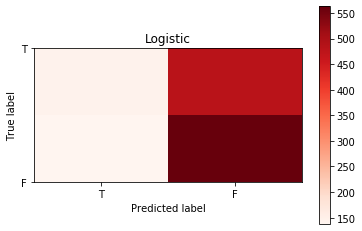

In [469]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_log), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'Logistic')

In [470]:
prediction=lr.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.53593153, 0.52082309, 0.53577107, ..., 0.61516605, 0.54762943,
       0.52493785])

(array([  1.,  25.,  91., 225., 520., 297.,  72.,  53.,  34.,   8.]),
 array([0.36859771, 0.40292798, 0.43725826, 0.47158853, 0.5059188 ,
        0.54024908, 0.57457935, 0.60890963, 0.6432399 , 0.67757017,
        0.71190045]),
 <a list of 10 Patch objects>)

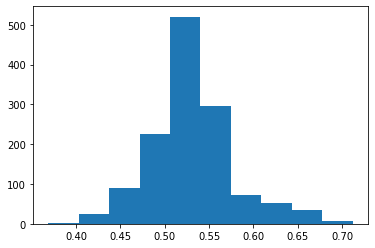

In [471]:
plt.hist(prediction)

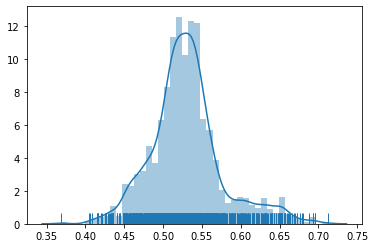

In [472]:
import seaborn as sns
sns.distplot(prediction, rug=True)

In [473]:
log_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
log_port

array([690.169983  , 679.27002   , 668.190002  , ..., 698.02759691,
       701.13155114, 731.58133482])

In [474]:
log_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
log_port1

array([690.169983  , 679.27002   , 668.190002  , ..., 510.86183043,
       513.13350528, 535.41863025])

In [475]:
log_port2=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
log_port2

array([690.169983  , 679.27002   , 668.190002  , ..., 698.02759691,
       701.13155114, 731.58133482])

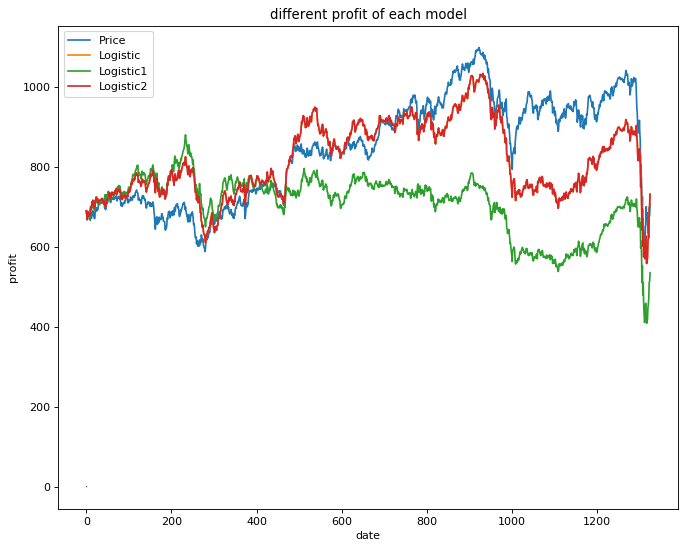

In [476]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(log_port, label='Logistic')
plt.plot(log_port1, label='Logistic1')
plt.plot(log_port2, label='Logistic2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## Logistic lasso

In [477]:
lasso = Lasso(alpha=0.0001)
lasso.fit(train_x,train_y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [478]:
pred_test_y3 = lasso.predict(test_x)
pred_train_y3 = lasso.predict(train_x)
pred_test_y3 = [1.0 if x > 0.5 else 0.0 for x in pred_test_y3]
pred_train_y3 = [1.0 if x > 0.5 else 0.0 for x in pred_train_y3]

In [479]:
print("Accuracy for train set",accuracy_score(train_y,pred_train_y3))
print("Accuracy for test set",accuracy_score(test_y,pred_test_y3))

Accuracy for train set 0.5479738562091503
Accuracy for test set 0.5339366515837104


In [480]:
print(confusion_matrix(test_y,pred_test_y3))
print(classification_report(test_y,pred_test_y3))

[[144 481]
 [137 564]]
              precision    recall  f1-score   support

         0.0       0.51      0.23      0.32       625
         1.0       0.54      0.80      0.65       701

    accuracy                           0.53      1326
   macro avg       0.53      0.52      0.48      1326
weighted avg       0.53      0.53      0.49      1326



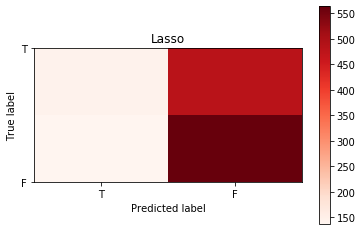

In [481]:
plot_confusion_matrix(confusion_matrix(test_y,pred_test_y3), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'Lasso')

In [482]:
prediction=lasso.predict(test_x)
prediction=pd.DataFrame(prediction)

prediction=prediction.values
prediction

array([[0.53631954],
       [0.52034536],
       [0.53729969],
       ...,
       [0.61351137],
       [0.54734818],
       [0.52662361]])

(array([  1.,  25., 101., 270., 543., 239.,  64.,  49.,  28.,   6.]),
 array([0.36991249, 0.40492232, 0.43993215, 0.47494197, 0.5099518 ,
        0.54496163, 0.57997146, 0.61498129, 0.64999112, 0.68500094,
        0.72001077]),
 <a list of 10 Patch objects>)

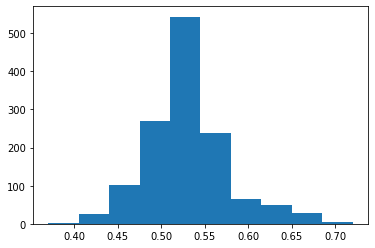

In [483]:
plt.hist(prediction)

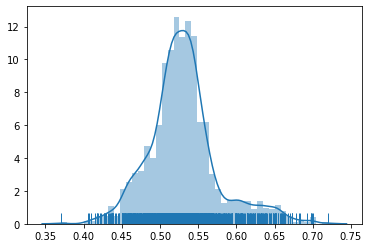

In [484]:
sns.distplot(prediction, rug=True)

In [485]:
lasso_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
lasso_port

array([690.169983  , 679.27002   , 668.190002  , ..., 585.32390517,
       587.92669425, 613.46004905])

In [486]:
lasso_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
lasso_port1

array([690.169983  , 679.27002   , 668.190002  , ..., 337.79512271,
       339.29721317, 354.03271712])

In [487]:
lasso_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
lasso_port2

array([690.169983  , 679.27002   , 668.190002  , ..., 519.87817661,
       522.1899449 , 544.8683864 ])

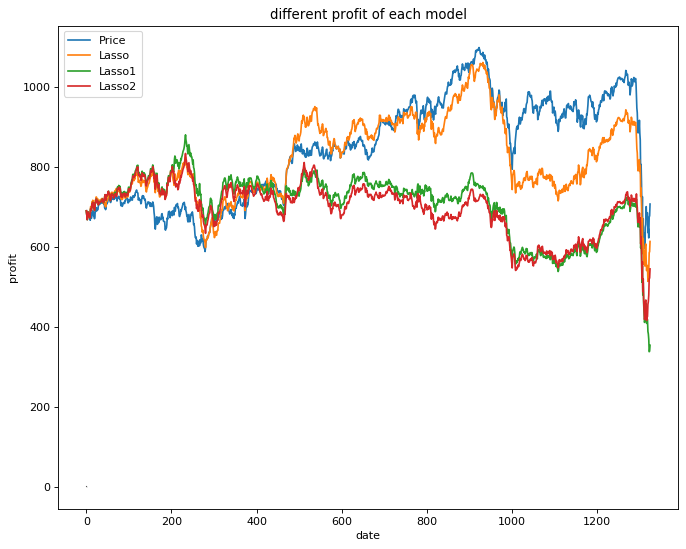

In [488]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(lasso_port, label='Lasso')
plt.plot(lasso_port1, label='Lasso1')
plt.plot(lasso_port2, label='Lasso2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## Logistic Ridge

In [489]:
ridge = Ridge(alpha=0)
ridge.fit(train_x,train_y)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [490]:
pred_test_y4 = ridge.predict(test_x)
pred_train_y4 = ridge.predict(train_x)
pred_test_y4 = [1.0 if x > 0.5 else 0.0 for x in pred_test_y4]
pred_train_y4 = [1.0 if x > 0.5 else 0.0 for x in pred_train_y4]

In [491]:
print("Accuracy for train set",accuracy_score(train_y,pred_train_y4))
print("Accuracy for test set",accuracy_score(test_y,pred_test_y4))

Accuracy for train set 0.5372549019607843
Accuracy for test set 0.5113122171945701


In [492]:
print(confusion_matrix(test_y,pred_test_y4))
print(classification_report(test_y,pred_test_y4))

[[250 375]
 [273 428]]
              precision    recall  f1-score   support

         0.0       0.48      0.40      0.44       625
         1.0       0.53      0.61      0.57       701

    accuracy                           0.51      1326
   macro avg       0.51      0.51      0.50      1326
weighted avg       0.51      0.51      0.51      1326



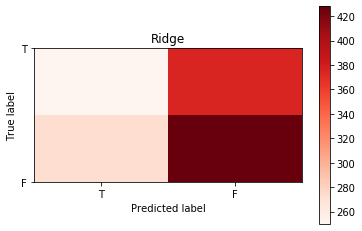

In [493]:
plot_confusion_matrix(confusion_matrix(test_y,pred_test_y4), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'Ridge')

In [494]:
prediction=ridge.predict(test_x)
prediction=pd.DataFrame(prediction)

prediction=prediction.values
prediction

array([[0.515625],
       [0.515625],
       [0.53125 ],
       ...,
       [0.609375],
       [0.546875],
       [0.515625]])

(array([  5.,  38., 153., 509., 420., 128.,  44.,  23.,   5.,   1.]),
 array([0.328125 , 0.3765625, 0.425    , 0.4734375, 0.521875 , 0.5703125,
        0.61875  , 0.6671875, 0.715625 , 0.7640625, 0.8125   ]),
 <a list of 10 Patch objects>)

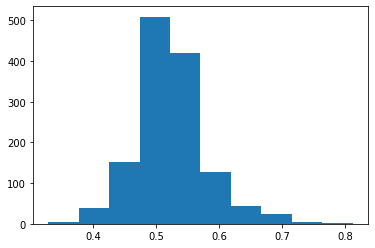

In [495]:
plt.hist(prediction)

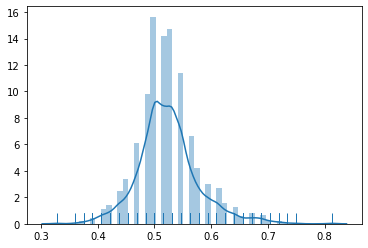

In [496]:
sns.distplot(prediction, rug=True)

In [497]:
ridge_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
ridge_port

array([690.169983  , 679.27002   , 668.190002  , ..., 601.40127454,
       604.07555567, 630.31024724])

In [498]:
ridge_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
ridge_port1

array([690.169983  , 690.169983  , 690.169983  , ..., 490.05650429,
       492.23566305, 513.61320545])

In [499]:
ridge_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
ridge_port2

array([690.169983  , 690.169983  , 690.169983  , ..., 415.89419307,
       417.74357058, 435.8859596 ])

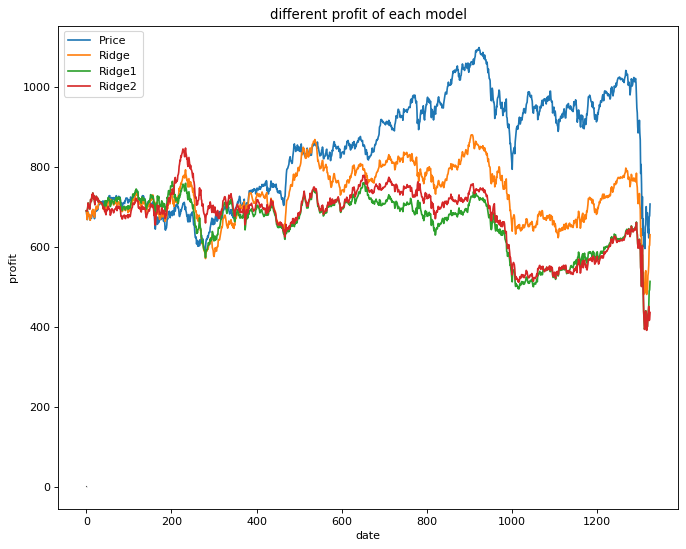

In [500]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(ridge_port, label='Ridge')
plt.plot(ridge_port1, label='Ridge1')
plt.plot(ridge_port2, label='Ridge2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## SVM Linear

In [501]:
svclassifier = SVC(kernel='linear',probability=True)
svm_linear=svclassifier.fit(train_x, train_y)

D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [502]:
svm_linear

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [503]:
train_score_svm_linear=svm_linear.score(train_x, train_y)
test_score_svm_linear=svm_linear.score(test_x, test_y)

In [504]:
train_score_svm_linear

0.5312418300653595

In [505]:
test_score_svm_linear

0.5301659125188537

In [506]:
y_pred_svm_linear = svclassifier.predict(test_x)

In [507]:
print(confusion_matrix(test_y,y_pred_svm_linear))
print(classification_report(test_y,y_pred_svm_linear))

[[ 29 596]
 [ 27 674]]
              precision    recall  f1-score   support

         0.0       0.52      0.05      0.09       625
         1.0       0.53      0.96      0.68       701

    accuracy                           0.53      1326
   macro avg       0.52      0.50      0.38      1326
weighted avg       0.52      0.53      0.40      1326



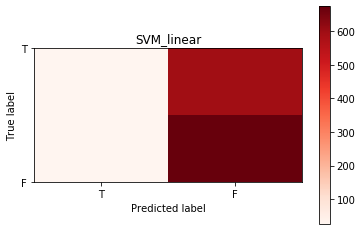

In [508]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_svm_linear), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'SVM_linear')

In [509]:
prediction=svclassifier.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.53044747, 0.51611672, 0.53044834, ..., 0.53044961, 0.53044949,
       0.53044572])

(array([  56.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1270.]),
 array([0.51609541, 0.517532  , 0.51896859, 0.52040517, 0.52184176,
        0.52327835, 0.52471494, 0.52615152, 0.52758811, 0.5290247 ,
        0.53046128]),
 <a list of 10 Patch objects>)

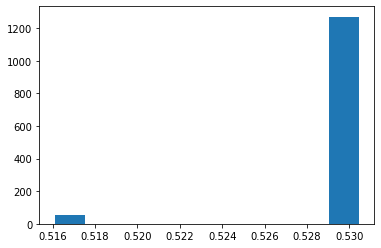

In [510]:
plt.hist(prediction)

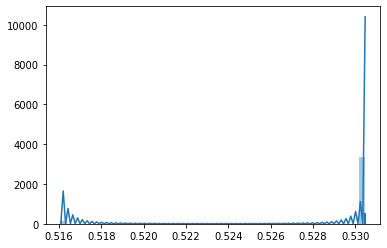

In [511]:
sns.distplot(prediction, rug=True)

In [512]:
svmlinear_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmlinear_port

array([690.169983, 679.27002 , 668.190002, ..., 674.650024, 677.650024,
       707.080017])

In [513]:
svmlinear_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmlinear_port1

array([690.169983  , 679.27002   , 690.350038  , ..., 730.29332622,
       733.54075808, 765.39805699])

In [514]:
svmlinear_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmlinear_port2

array([690.169983  , 679.27002   , 690.350038  , ..., 730.29332622,
       733.54075808, 765.39805699])

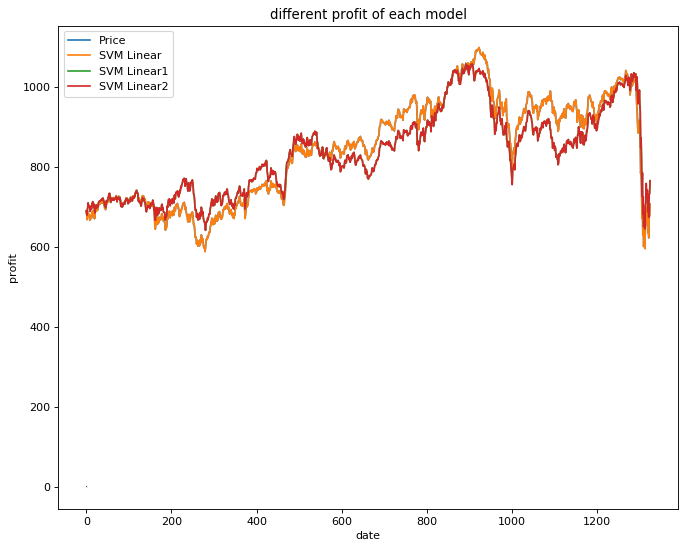

In [515]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(svmlinear_port, label='SVM Linear')
plt.plot(svmlinear_port2, label='SVM Linear1')
plt.plot(svmlinear_port2, label='SVM Linear2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## SVM Polynomial

In [516]:
def svm_cross_validation(train_x, train_y):  
    model = SVC(kernel='poly', probability=True)  
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001],'degree':[1,3,5,7,9,11]}  
    grid_search = GridSearchCV(model, param_grid, n_jobs = 8, verbose=1)  
    grid_search.fit(train_x, train_y)  
    best_parameters = grid_search.best_estimator_.get_params()  
    for para, val in list(best_parameters.items()):  
        print(para, val)  
    model = SVC(kernel='poly', C=best_parameters['C'], gamma=best_parameters['gamma'], degree=best_parameters['degree'], probability=True)  
    model.fit(train_x, train_y)  
    return model

In [517]:
svm_poly=svm_cross_validation(train_x, train_y)

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   28.6s
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:   40.5s finished
D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C 0.001
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 1
gamma 0.001
kernel poly
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False


D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [518]:
svm_poly

SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [519]:
y_pred_svm_poly= svm_poly.predict(test_x)

In [520]:
train_score_svm_poly=svm_poly.score(train_x, train_y)
test_score_svm_poly=svm_poly.score(test_x, test_y)

In [521]:
train_score_svm_poly

0.5288888888888889

In [522]:
test_score_svm_poly

0.528657616892911

In [523]:
print(confusion_matrix(test_y,y_pred_svm_poly))
print(classification_report(test_y,y_pred_svm_poly))

[[  0 625]
 [  0 701]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       625
         1.0       0.53      1.00      0.69       701

    accuracy                           0.53      1326
   macro avg       0.26      0.50      0.35      1326
weighted avg       0.28      0.53      0.37      1326



D:\software\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


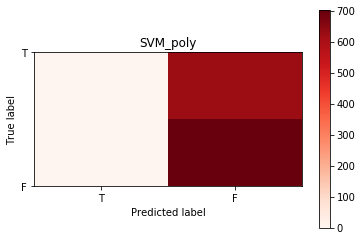

In [524]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_svm_poly), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'SVM_poly')

In [525]:
prediction=svm_poly.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.53137329, 0.5302792 , 0.53679008, ..., 0.5302792 , 0.53775027,
       0.53480674])

(array([  3.,  10.,  18.,  61., 140., 103., 287., 652.,  44.,   8.]),
 array([0.50528391, 0.5095517 , 0.5138195 , 0.5180873 , 0.52235509,
        0.52662289, 0.53089068, 0.53515848, 0.53942628, 0.54369407,
        0.54796187]),
 <a list of 10 Patch objects>)

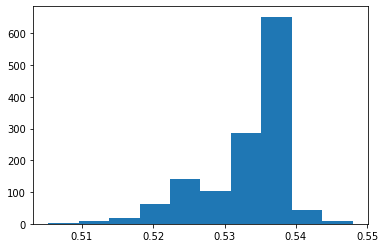

In [526]:
plt.hist(prediction)

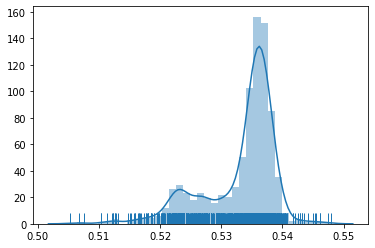

In [527]:
sns.distplot(prediction, rug=True)

In [528]:
svmpoly_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmpoly_port

array([690.169983, 679.27002 , 668.190002, ..., 674.650024, 677.650024,
       707.080017])

In [529]:
svmpoly_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmpoly_port1

array([690.169983  , 679.27002   , 668.190002  , ..., 580.40884474,
       582.98977778, 608.30872483])

In [530]:
svmpoly_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmpoly_port2

array([690.169983  , 679.27002   , 668.190002  , ..., 580.40884474,
       582.98977778, 608.30872483])

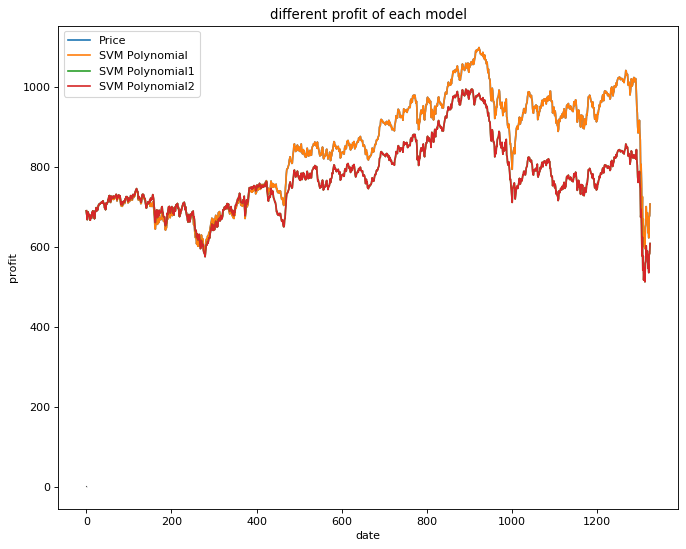

In [531]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(svmpoly_port, label='SVM Polynomial')
plt.plot(svmpoly_port1, label='SVM Polynomial1')
plt.plot(svmpoly_port2, label='SVM Polynomial2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

##  SVM RBF

In [532]:
def svm_cross_validation(train_x, train_y):       
    model = SVC(kernel='rbf', probability=True)    
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}    
    grid_search = GridSearchCV(model, param_grid, n_jobs = 8, verbose=1)    
    grid_search.fit(train_x, train_y)    
    best_parameters = grid_search.best_estimator_.get_params()    
    for para, val in list(best_parameters.items()):    
        print(para, val)    
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)    
    model.fit(train_x, train_y)    
    return model

In [533]:
svm_RBF=svm_cross_validation(train_x, train_y)

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:   13.1s finished
D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C 0.001
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 3
gamma 0.001
kernel rbf
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False


D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [534]:
train_score_svm_RBF=svm_RBF.score(train_x, train_y)
test_score_svm_RBF=svm_RBF.score(test_x, test_y)

In [535]:
train_score_svm_RBF

0.5288888888888889

In [536]:
test_score_svm_RBF

0.528657616892911

In [537]:
y_pred_svm_RBF = svm_RBF.predict(test_x)

In [538]:
print(confusion_matrix(test_y,y_pred_svm_RBF))
print(classification_report(test_y,y_pred_svm_RBF))

[[  0 625]
 [  0 701]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       625
         1.0       0.53      1.00      0.69       701

    accuracy                           0.53      1326
   macro avg       0.26      0.50      0.35      1326
weighted avg       0.28      0.53      0.37      1326



D:\software\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


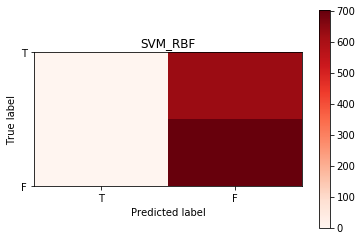

In [539]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_svm_RBF), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'SVM_RBF')

In [540]:
prediction=svm_RBF.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.54646348, 0.51376343, 0.55423368, ..., 0.53445281, 0.56062216,
       0.54563133])

(array([  5.,   9.,  18.,  79., 109., 116., 339., 619.,  22.,  10.]),
 array([0.42385919, 0.44199253, 0.46012587, 0.4782592 , 0.49639254,
        0.51452587, 0.53265921, 0.55079255, 0.56892588, 0.58705922,
        0.60519255]),
 <a list of 10 Patch objects>)

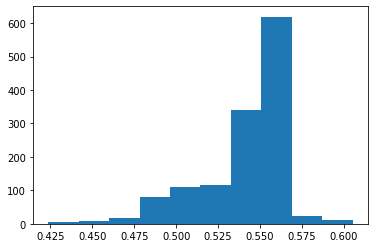

In [541]:
plt.hist(prediction)

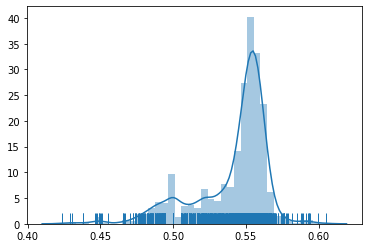

In [542]:
sns.distplot(prediction, rug=True)

In [543]:
svmrbf_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmrbf_port

array([690.169983  , 679.27002   , 668.190002  , ..., 587.05979719,
       589.67030535, 615.27938429])

In [544]:
svmrbf_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmrbf_port1

array([690.169983  , 679.27002   , 690.350038  , ..., 430.37034069,
       432.28409001, 451.05796633])

In [545]:
svmrbf_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmrbf_port2

array([690.169983  , 679.27002   , 690.350038  , ..., 438.33777231,
       440.2869508 , 459.40838727])

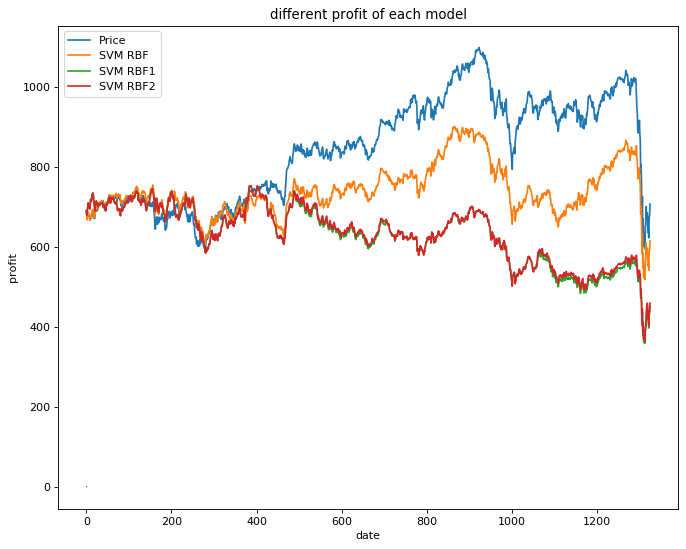

In [546]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(svmrbf_port, label='SVM RBF')
plt.plot(svmrbf_port1, label='SVM RBF1')
plt.plot(svmrbf_port2, label='SVM RBF2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## SVM Sigmoid

In [547]:
def svm_cross_validation(train_x, train_y):       
    model = SVC(kernel='sigmoid', probability=True)    
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}    
    grid_search = GridSearchCV(model, param_grid, n_jobs = 8, verbose=1)    
    grid_search.fit(train_x, train_y)    
    best_parameters = grid_search.best_estimator_.get_params()    
    for para, val in list(best_parameters.items()):    
        print(para, val)    
    model = SVC(kernel='sigmoid', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)    
    model.fit(train_x, train_y)    
    return model

In [548]:
svm_sig=svm_cross_validation(train_x, train_y)

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:   12.8s finished
D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C 0.001
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 3
gamma 0.001
kernel sigmoid
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False


D:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [549]:
train_score_svm_sig=svm_sig.score(train_x, train_y)
test_score_svm_sig=svm_sig.score(test_x, test_y)

In [550]:
train_score_svm_sig

0.5288888888888889

In [551]:
test_score_svm_sig

0.528657616892911

In [552]:
y_pred_svm_sig = svm_sig.predict(test_x)

In [553]:
print(confusion_matrix(test_y,y_pred_svm_sig))
print(classification_report(test_y,y_pred_svm_sig))

[[  0 625]
 [  0 701]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       625
         1.0       0.53      1.00      0.69       701

    accuracy                           0.53      1326
   macro avg       0.26      0.50      0.35      1326
weighted avg       0.28      0.53      0.37      1326



D:\software\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


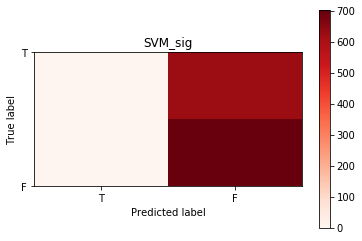

In [554]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_svm_sig), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'SVM_sig')

In [555]:
prediction=svm_sig.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.58170636, 0.53473236, 0.61309268, ..., 0.58108033, 0.61817061,
       0.59282113])

(array([  8.,   6.,  12.,  48., 139., 103., 154., 757.,  88.,  11.]),
 array([0.40713856, 0.43396463, 0.4607907 , 0.48761678, 0.51444285,
        0.54126892, 0.568095  , 0.59492107, 0.62174714, 0.64857321,
        0.67539929]),
 <a list of 10 Patch objects>)

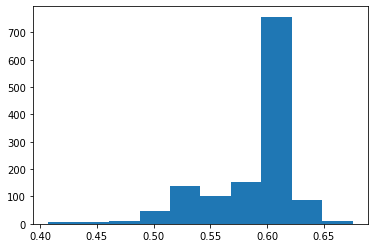

In [556]:
plt.hist(prediction)

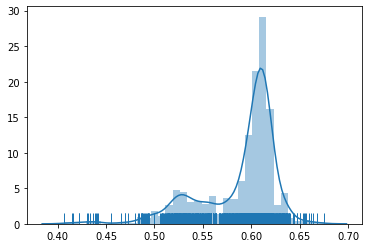

In [557]:
sns.distplot(prediction, rug=True)

In [558]:
svmsig_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmsig_port

array([690.169983  , 679.27002   , 668.190002  , ..., 554.97782085,
       557.44566848, 581.65524796])

In [559]:
svmsig_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmsig_port1

array([690.169983  , 679.27002   , 668.190002  , ..., 670.02277445,
       673.00219823, 702.23033854])

In [560]:
svmsig_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
svmsig_port2

array([690.169983  , 679.27002   , 668.190002  , ..., 640.522818  ,
       643.37106285, 671.31233814])

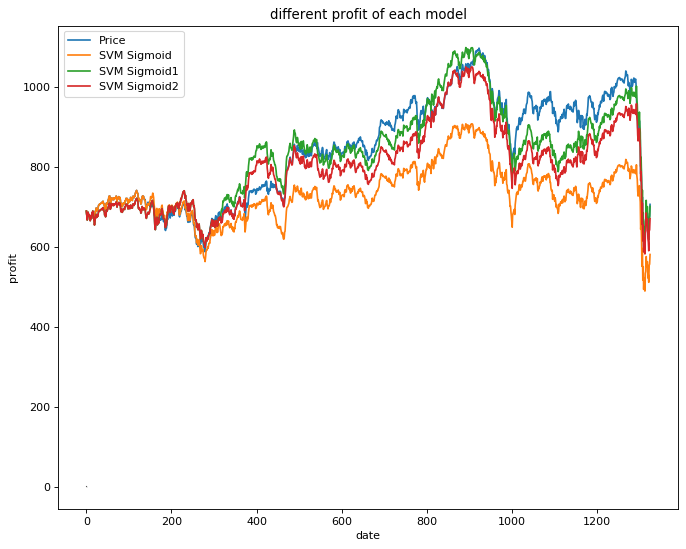

In [561]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(svmsig_port, label='SVM Sigmoid')
plt.plot(svmsig_port1, label='SVM Sigmoid1')
plt.plot(svmsig_port2, label='SVM Sigmoid2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

# Decision tree

In [562]:
clf = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy', min_samples_split=10, min_samples_leaf=6, max_leaf_nodes=4)
clf1 = clf.fit(train_x, train_y)

In [563]:
train_score=clf.score(train_x, train_y)
train_score

0.537516339869281

In [564]:
test_score1=clf.score(test_x, test_y)
test_score1

0.5331825037707391

In [565]:
y_pred_tree = clf.predict(test_x)

In [566]:
print(confusion_matrix(test_y,y_pred_tree))
print(classification_report(test_y,y_pred_tree))

[[ 47 578]
 [ 41 660]]
              precision    recall  f1-score   support

         0.0       0.53      0.08      0.13       625
         1.0       0.53      0.94      0.68       701

    accuracy                           0.53      1326
   macro avg       0.53      0.51      0.41      1326
weighted avg       0.53      0.53      0.42      1326



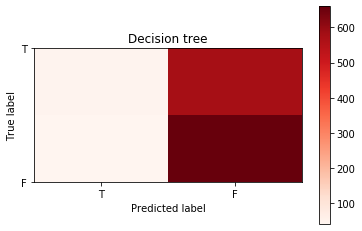

In [567]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_tree), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'Decision tree')

In [568]:
prediction=clf.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.51624714, 0.55717971, 0.55717971, ..., 0.68656716, 0.55717971,
       0.55717971])

(array([ 88.,   0., 786.,   0., 401.,   0.,   0.,   0.,   0.,  51.]),
 array([0.45189504, 0.47536226, 0.49882947, 0.52229668, 0.54576389,
        0.5692311 , 0.59269832, 0.61616553, 0.63963274, 0.66309995,
        0.68656716]),
 <a list of 10 Patch objects>)

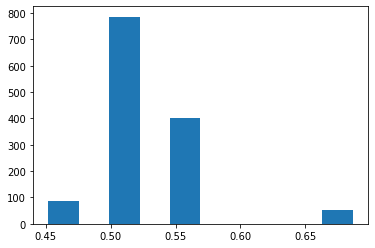

In [569]:
plt.hist(prediction)

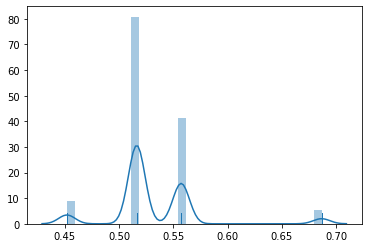

In [570]:
sns.distplot(prediction, rug=True)

In [571]:
tree_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
tree_port

array([690.169983  , 679.27002   , 668.190002  , ..., 794.96171708,
       798.4967131 , 833.17501583])

In [572]:
tree_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
tree_port1

array([690.169983  , 690.169983  , 678.91216857, ..., 611.2185441 ,
       613.93648017, 640.59942664])

In [573]:
tree_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
tree_port2

array([690.169983  , 690.169983  , 678.91216857, ..., 611.2185441 ,
       613.93648017, 640.59942664])

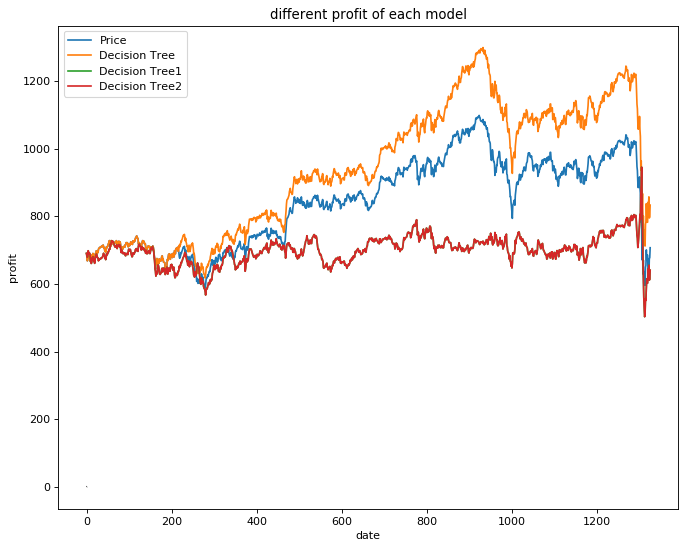

In [574]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(tree_port, label='Decision Tree')
plt.plot(tree_port1, label='Decision Tree1')
plt.plot(tree_port2, label='Decision Tree2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

[Text(167.4, 181.2, 'X[1] <= 0.059\nentropy = 0.998\nsamples = 3825\nvalue = [1802, 2023]'),
 Text(83.7, 108.72, 'X[4] <= 0.5\nentropy = 0.986\nsamples = 1297\nvalue = [557, 740]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.991\nsamples = 1163\nvalue = [515, 648]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.897\nsamples = 134\nvalue = [42, 92]'),
 Text(251.10000000000002, 108.72, 'X[1] <= 0.415\nentropy = 1.0\nsamples = 2528\nvalue = [1245, 1283]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.999\nsamples = 2185\nvalue = [1057, 1128]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.993\nsamples = 343\nvalue = [188, 155]')]

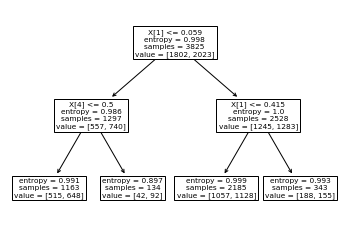

In [575]:
tree.plot_tree(clf1.fit(train_x,train_y))

# Random Forest

In [576]:
rfc = RandomForestClassifier(max_depth=2)
rfc.fit(train_x, train_y)

D:\software\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [577]:
train_score=rfc.score(train_x, train_y)
train_score

0.5333333333333333

In [578]:
test_score=rfc.score(test_x, test_y)
test_score

0.5279034690799397

In [579]:
y_pred_forest1 = rfc.predict(test_x)

In [580]:
print(confusion_matrix(test_y,y_pred_forest1))
print(classification_report(test_y,y_pred_forest1))

[[ 21 604]
 [ 22 679]]
              precision    recall  f1-score   support

         0.0       0.49      0.03      0.06       625
         1.0       0.53      0.97      0.68       701

    accuracy                           0.53      1326
   macro avg       0.51      0.50      0.37      1326
weighted avg       0.51      0.53      0.39      1326



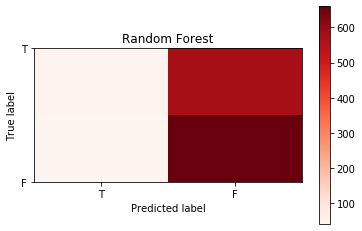

In [581]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_tree), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'Random Forest')

In [582]:
prediction=rfc.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.51636837, 0.50293465, 0.52551923, ..., 0.5458541 , 0.52551923,
       0.5359804 ])

(array([ 21.,  22., 138., 963., 109.,  41.,   4.,   7.,  13.,   8.]),
 array([0.4674977 , 0.48385813, 0.50021857, 0.516579  , 0.53293944,
        0.54929987, 0.56566031, 0.58202075, 0.59838118, 0.61474162,
        0.63110205]),
 <a list of 10 Patch objects>)

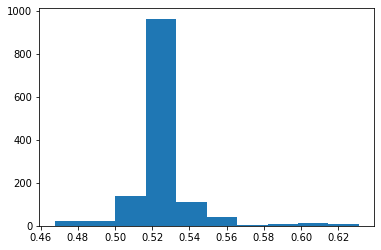

In [583]:
plt.hist(prediction)

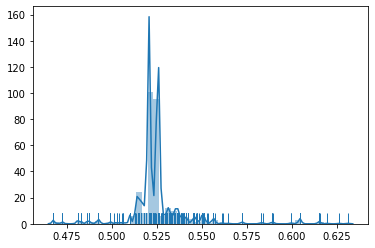

In [584]:
sns.distplot(prediction, rug=True)

In [585]:
prediction.dtype

dtype('float64')

In [586]:
forest_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
forest_port

array([690.169983  , 679.27002   , 668.190002  , ..., 609.75423839,
       612.46566305, 639.06473269])

In [587]:
forest_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
forest_port1

array([690.169983  , 690.169983  , 690.169983  , ..., 427.52444575,
       429.42554008, 448.07527105])

In [588]:
forest_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
forest_port2

array([690.169983  , 690.169983  , 690.169983  , ..., 440.98700839,
       442.94796737, 462.18497043])

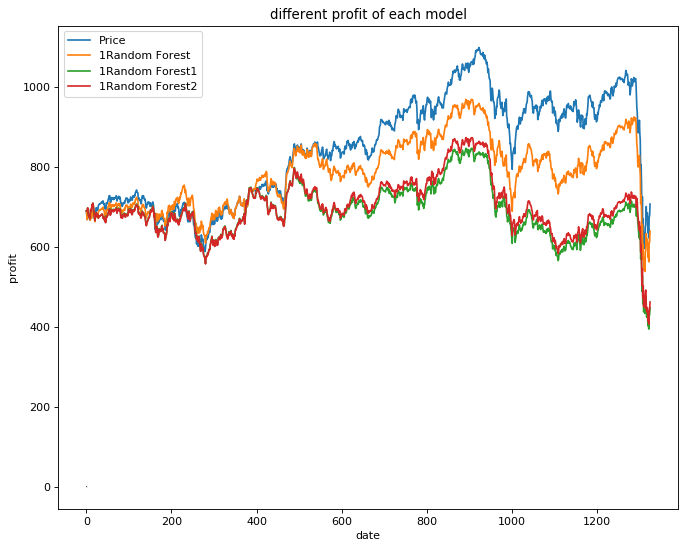

In [589]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(forest_port, label='1Random Forest')
plt.plot(forest_port1, label='1Random Forest1')
plt.plot(forest_port2, label='1Random Forest2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

In [590]:
param_test1 = {'n_estimators':range(10,71,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(train_x, train_y)
gsearch1.best_params_, gsearch1.best_score_

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

({'n_estimators': 20}, 0.515538713161354)

In [591]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(train_x, train_y)
gsearch2.best_params_, gsearch2.best_score_

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

({'max_depth': 3, 'min_samples_split': 50}, 0.5259302859691598)

In [592]:
param_test3 = {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, max_depth=5,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(train_x, train_y)
gsearch3.best_params_, gsearch3.best_score_

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

({'min_samples_leaf': 20, 'min_samples_split': 140}, 0.524264708718401)

In [593]:
param_test4 = {'max_features':range(3,11,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 70, max_depth=5, min_samples_split=140,
                                  min_samples_leaf=10 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(train_x, train_y)
gsearch4.best_params_, gsearch4.best_score_

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\software\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

({'max_features': 5}, 0.5218564542618381)

In [594]:
rf2 = RandomForestClassifier(n_estimators= 70, max_depth=5, min_samples_split=140,
                                  min_samples_leaf=10,max_features=9 ,oob_score=True, random_state=10)
rf2.fit(train_x, train_y)
print (rf2.oob_score_)

D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.5189542483660131


In [595]:
train_score=rf2.score(train_x, train_y)
train_score

0.5579084967320261

In [596]:
test_score=rf2.score(test_x, test_y)
test_score

0.5369532428355958

In [597]:
test_score=rf2.score(test_x, test_y)
test_score

0.5369532428355958

In [598]:
y_pred_forest2 = rf2.predict(test_x)

In [599]:
print(confusion_matrix(test_y,y_pred_forest2))
print(classification_report(test_y,y_pred_forest2))

[[ 96 529]
 [ 85 616]]
              precision    recall  f1-score   support

         0.0       0.53      0.15      0.24       625
         1.0       0.54      0.88      0.67       701

    accuracy                           0.54      1326
   macro avg       0.53      0.52      0.45      1326
weighted avg       0.53      0.54      0.47      1326



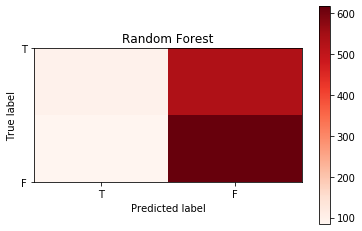

In [600]:
plot_confusion_matrix(confusion_matrix(test_y,y_pred_forest2), labels_name = pd.DataFrame(['TT','TF'],['FT','FF']), title = 'Random Forest')

In [601]:
prediction=rf2.predict_proba(test_x)
prediction=pd.DataFrame(prediction)
prediction=prediction[1]
prediction=prediction.values
prediction

array([0.51970888, 0.55425344, 0.56381962, ..., 0.62834258, 0.56300904,
       0.54528557])

(array([ 24.,  42.,  95., 544., 333., 182.,  40.,  30.,  27.,   9.]),
 array([0.41749088, 0.4445903 , 0.47168972, 0.49878914, 0.52588856,
        0.55298798, 0.5800874 , 0.60718682, 0.63428624, 0.66138566,
        0.68848508]),
 <a list of 10 Patch objects>)

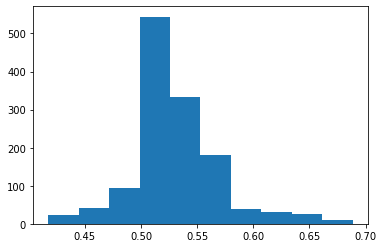

In [602]:
plt.hist(prediction)

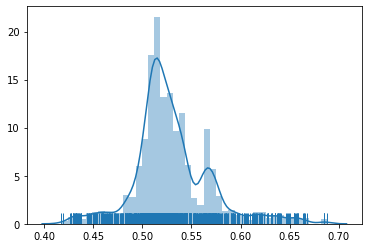

In [603]:
sns.distplot(prediction, rug=True)

In [604]:
forest2_port=portfolio_generator1(690.169983,prediction,price,leverage = 1,short = True, transc =0)
forest2_port

array([690.169983  , 679.27002   , 668.190002  , ..., 702.70558485,
       705.83034091, 736.48419062])

In [605]:
forest2_port1=portfolio_generator2(690.169983,prediction,price,leverage = 1,short = True, transc =0)
forest2_port1

array([690.169983  , 690.169983  , 678.91216857, ..., 594.06196883,
       596.70361389, 622.61814582])

In [606]:
forest2_port2=portfolio_generator3(690.169983,prediction,price,leverage = 1,short = True, transc =0)
forest2_port2

array([690.169983  , 690.169983  , 678.91216857, ..., 585.49308   ,
       588.09662136, 613.63735602])

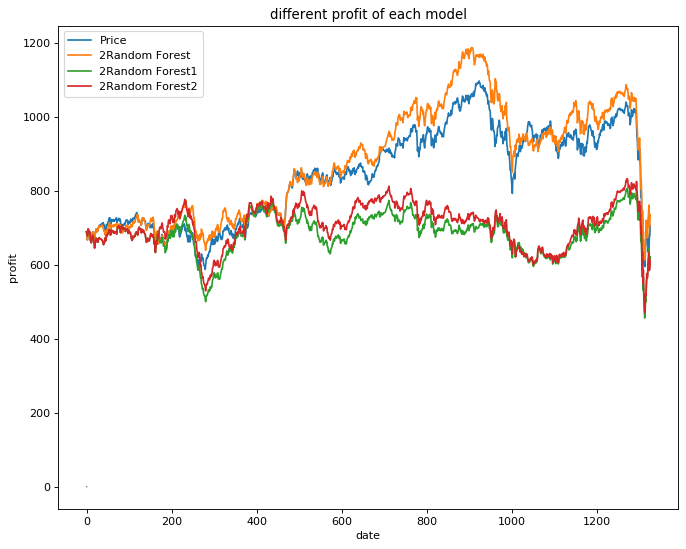

In [607]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(forest2_port, label='2Random Forest')
plt.plot(forest2_port1, label='2Random Forest1')
plt.plot(forest2_port2, label='2Random Forest2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

# LSTM

In [608]:
class RNNModel():
    
    def train_single_lstm(self, X, Y):
        assert len(X) == len(Y)
        self.model = Sequential()
        self.model.add(LSTM(units=128, input_shape=(X.shape[1], X.shape[2])))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(units = 1))
        self.model.add(Activation('sigmoid'))
        self.model.summary()
        #Pre-training
        #L2-regularization
        #Learning rate (Log scale)
        #Number of units and Number of epochs
        optimizer = optimizers.Adam(lr = 0.001)
        self.model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        es = EarlyStopping(monitor='loss', mode = 'min', verbose = 1)
        self.model.fit(X, Y, epochs = 100, batch_size = 64, callbacks = [es])
        
    def train_multi_lstm(self, X, Y):
        assert len(X) == len(Y)
        self.model = Sequential()
        self.model.add(LSTM(units=128, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(units=128, return_sequences = True))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.7))
        self.model.add(LSTM(units=128))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units = 1))
        self.model.add(Activation('sigmoid'))
        self.model.summary()
        #Pre-training
        #L2-regularization
        #Learning rate (Log scale)
        #Number of units and Number of epochs
        optimizer = optimizers.Adam(lr = 0.001)
        self.model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        es = EarlyStopping(monitor='loss', mode = 'min', verbose = 1)
        self.model.fit(X, Y, epochs = 100, batch_size = 64, callbacks = [es])


    def train_GRU(self, X, Y):
        assert len(X) == len(Y)
        self.model = Sequential()
        self.model.add(GRU(units=128, input_shape=(X.shape[1], X.shape[2])))
        self.model.add(Activation('relu'))
        self.model.add(Dense(units = 1))
        self.model.add(Activation('sigmoid'))
        self.model.summary()
        #Pre-training
        #L2-regularization
        #Learning rate (Log scale)
        #Number of units and Number of epochs
        optimizer = optimizers.Adam(lr = 0.001)
        self.model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        es = EarlyStopping(monitor='loss', mode = 'min', verbose = 1)
        self.model.fit(X, Y, epochs = 100, batch_size = 64, callbacks = [es])
        #return self.model
    
    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X, Y):
        score, acc = self.model.evaluate(X, Y, verbose = 1)
        return -acc

In [609]:
look_back = 10
def create_dataset(Xtrain, Ytrain, look_back):
    dataX, dataY = [], []
    for i in range(len(Xtrain)-look_back-1):
        a = Xtrain[i:(i+look_back)]
        dataX.append(a)
        dataY.append(Ytrain[i + look_back])
    return np.array(dataX), np.array(dataY)

In [610]:
train_x1=train_x.values
train_y1=train_y.values
test_x1=test_x.values
test_y1=test_y.values

In [611]:
trainX, trainY = create_dataset(train_x1, train_y1, look_back)
testX, testY = create_dataset(test_x1, test_y1, look_back)

## Single

In [612]:
model_single_lstm = RNNModel()
model_single_lstm.train_single_lstm(trainX, trainY) 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               74752     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_13 (Activation)   (None, 1)                 0         
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3814/3814 [==============================] - 2s 641us/step - loss: 0.6985 - accuracy: 0.5063
Epoch 2/100
3814/3814 [==============================] - 2s 483us/step - loss: 0.6949 - accuracy: 0.5092
Epoch 3/100
3814/3814 [===============

In [613]:
y_true = testY[look_back+1:].ravel()

In [614]:
single_lstm_pred = model_single_lstm.predict(testX)
gru_pred = pd.DataFrame(single_lstm_pred)
acc = model_single_lstm.evaluate(testX, testY)
print("Acuuracy (Single LSTM)" + str(-acc))

1315/1315 [==============================] - 0s 236us/step
Acuuracy (Single LSTM)0.5079848170280457


In [615]:
single_lstm_pred

array([[0.5244482 ],
       [0.51481414],
       [0.5242614 ],
       ...,
       [0.507059  ],
       [0.51240134],
       [0.5218834 ]], dtype=float32)

In [616]:
prediction=model_single_lstm.predict(testX)
prediction=pd.DataFrame(prediction)

prediction=prediction.values
prediction

array([[0.5244482 ],
       [0.51481414],
       [0.5242614 ],
       ...,
       [0.507059  ],
       [0.51240134],
       [0.5218834 ]], dtype=float32)

(array([ 13.,  64., 255., 447., 280., 157.,  77.,  15.,   5.,   2.]),
 array([0.4716346 , 0.48310852, 0.49458247, 0.5060564 , 0.5175303 ,
        0.5290043 , 0.5404782 , 0.5519522 , 0.56342614, 0.57490003,
        0.586374  ], dtype=float32),
 <a list of 10 Patch objects>)

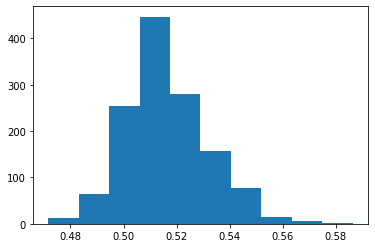

In [617]:
plt.hist(prediction)

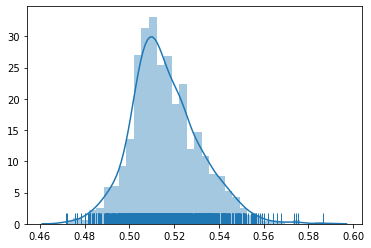

In [618]:
sns.distplot(prediction, rug=True)

In [619]:
prediction.shape

(1315, 1)

In [620]:
price1=data['Price']
price1=price1.iloc[3836:].values
price1

array([673.450012, 671.700012, 685.859985, ..., 674.650024, 677.650024,
       707.080017])

In [621]:
single_port=portfolio_generator1(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
single_port

array([673.450012  , 671.700012  , 685.859985  , ..., 532.29222365,
       534.6591941 , 557.87916869])

In [622]:
single_port1=portfolio_generator2(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
single_port1

array([ 673.450012  ,  671.700012  ,  657.540039  , ..., 1188.91162518,
       1183.6248324 , 1235.02905183])

In [623]:
single_port2=portfolio_generator3(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
single_port2

array([673.450012  , 671.700012  , 657.540039  , ..., 904.38394183,
       908.40551113, 868.95392567])

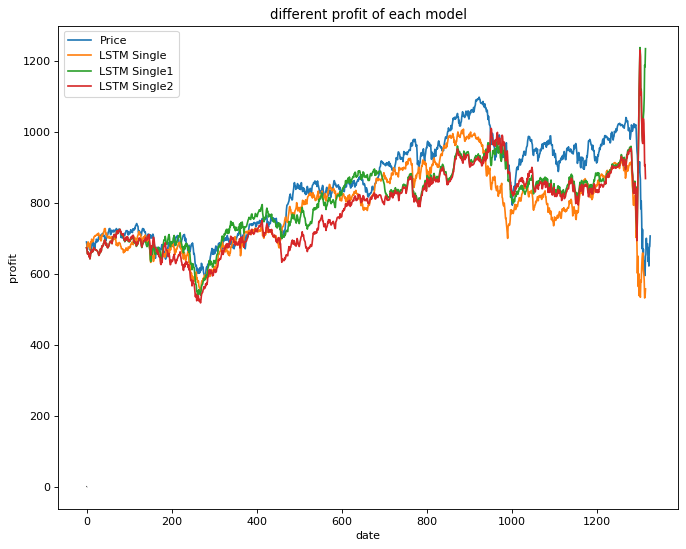

In [624]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(single_port, label='LSTM Single')
plt.plot(single_port1, label='LSTM Single1')
plt.plot(single_port2, label='LSTM Single2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## Multiple

In [625]:
model_multi_lstm = RNNModel()
model_multi_lstm.train_multi_lstm(trainX, trainY)
multi_lstm_pred = model_multi_lstm.predict(testX)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 128)           74752     
_________________________________________________________________
activation_14 (Activation)   (None, 10, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 128)           131584    
_________________________________________________________________
activation_15 (Activation)   (None, 10, 128)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)              

In [626]:
multi_lstm_pred = model_multi_lstm.predict(testX)
multi_lstm_pred = pd.DataFrame(multi_lstm_pred)
acc = model_multi_lstm.evaluate(testX, testY)
print("Acuuracy (Multiple LSTM)" + str(-acc))

1315/1315 [==============================] - 1s 530us/step
Acuuracy (Multiple LSTM)0.5300379991531372


In [627]:
prediction=model_multi_lstm.predict(testX)
prediction=pd.DataFrame(prediction)

prediction=prediction.values
prediction

array([[0.5247368 ],
       [0.5255948 ],
       [0.5273766 ],
       ...,
       [0.5218738 ],
       [0.52208066],
       [0.52230155]], dtype=float32)

(array([ 38.,  85., 213., 343., 332., 174.,  77.,  38.,  12.,   3.]),
 array([0.51904   , 0.520121  , 0.52120197, 0.52228296, 0.52336395,
        0.52444494, 0.52552587, 0.52660686, 0.52768785, 0.52876884,
        0.5298498 ], dtype=float32),
 <a list of 10 Patch objects>)

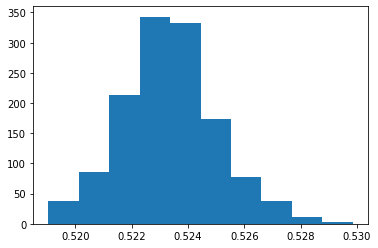

In [628]:
plt.hist(prediction)

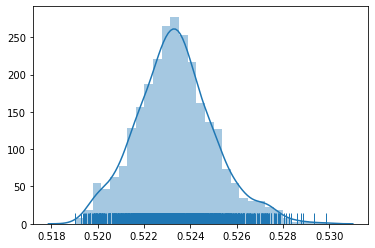

In [629]:
sns.distplot(prediction, rug=True)

In [630]:
prediction.shape

(1315, 1)

In [631]:
multiple_port=portfolio_generator1(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
multiple_port

array([673.450012, 671.700012, 685.859985, ..., 674.650024, 677.650024,
       707.080017])

In [632]:
multiple_port1=portfolio_generator2(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
multiple_port1

array([673.450012  , 671.700012  , 685.859985  , ..., 776.09815351,
       779.54926798, 813.40469289])

In [633]:
multiple_port2=portfolio_generator3(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
multiple_port2

array([673.450012  , 671.700012  , 685.859985  , ..., 776.09815351,
       779.54926798, 813.40469289])

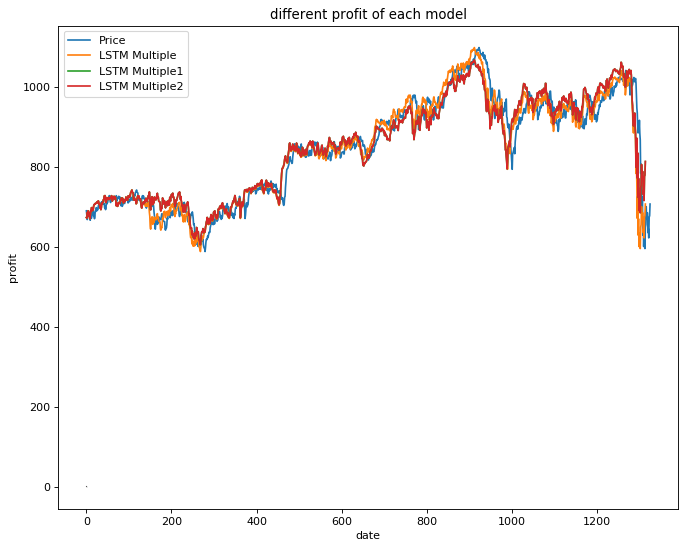

In [634]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(multiple_port, label='LSTM Multiple')
plt.plot(multiple_port1, label='LSTM Multiple1')
plt.plot(multiple_port2, label='LSTM Multiple2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

## RNN

In [635]:
model_gru = RNNModel()
model_gru.train_GRU(trainX, trainY)
gru_pred = model_gru.predict(testX)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 128)               56064     
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total params: 56,193
Trainable params: 56,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3814/3814 [==============================] - 3s 679us/step - loss: 0.6926 - accuracy: 0.5231
Epoch 2/100
3814/3814 [==============================] - 2s 503us/step - loss: 0.6920 - accuracy: 0.5197
Epoch 3/100
3814/3814 [===============

In [636]:
gru_pred = model_gru.predict(testX)
gru_pred = pd.DataFrame(gru_pred)
acc = model_gru.evaluate(testX, testY)
print("Acuuracy (GRU)" + str(-acc))

1315/1315 [==============================] - 0s 261us/step
Acuuracy (GRU)0.47756654024124146


In [637]:
prediction=model_gru.predict(testX)
prediction=pd.DataFrame(prediction)

prediction=prediction.values
prediction

array([[8.6443794e-01],
       [9.9998081e-01],
       [9.9953330e-01],
       ...,
       [7.8608270e-04],
       [9.8609853e-01],
       [9.0987718e-01]], dtype=float32)

(array([380.,  70.,  60.,  47.,  54.,  62.,  71.,  68.,  81., 422.]),
 array([2.93652135e-07, 1.00000255e-01, 2.00000212e-01, 3.00000161e-01,
        4.00000125e-01, 5.00000060e-01, 6.00000024e-01, 6.99999988e-01,
        7.99999952e-01, 8.99999917e-01, 9.99999881e-01], dtype=float32),
 <a list of 10 Patch objects>)

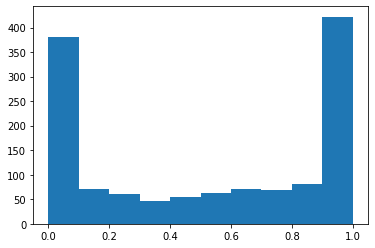

In [638]:
plt.hist(prediction)

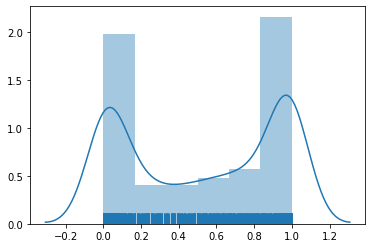

In [639]:
sns.distplot(prediction, rug=True)

In [640]:
prediction.shape

(1315, 1)

In [641]:
rnn_port=portfolio_generator1(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
rnn_port

array([673.450012  , 671.700012  , 685.859985  , ..., 805.58966474,
       801.66589214, 836.48183069])

In [642]:
rnn_port1=portfolio_generator2(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
rnn_port1

array([673.450012  , 671.700012  , 685.859985  , ..., 774.91761177,
       771.14323304, 804.63358816])

In [643]:
rnn_port2=portfolio_generator3(673.450012,prediction,price1,leverage = 1,short = True, transc =0)
rnn_port2

array([673.450012  , 671.700012  , 685.859985  , ..., 813.00187082,
       809.0419957 , 844.17827464])

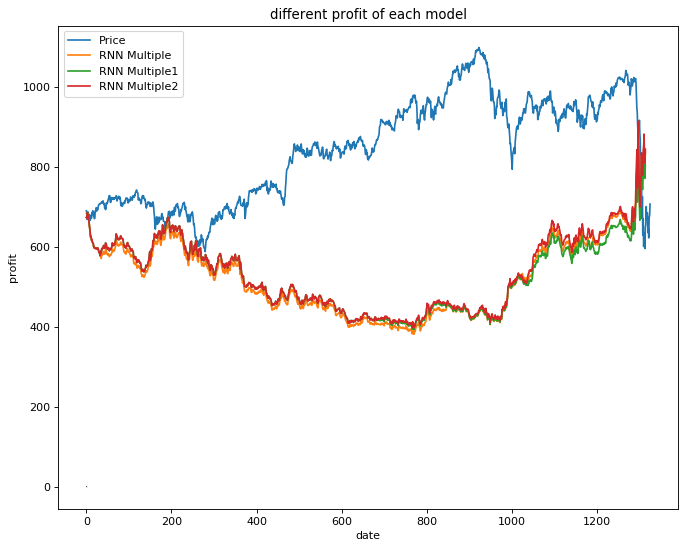

In [644]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(price, label='Price')
plt.plot(rnn_port, label='RNN Multiple')
plt.plot(rnn_port1, label='RNN Multiple1')
plt.plot(rnn_port2, label='RNN Multiple2')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()

# ROC

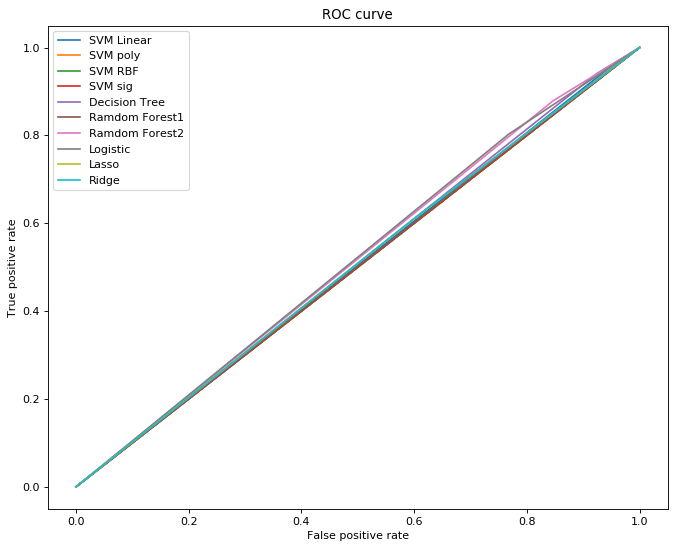

In [645]:
fpr_svm_linear, tpr_svm_linear, threshold = roc_curve(test_y,y_pred_svm_linear)
fpr_svm_poly, tpr_svm_poly, threshold = roc_curve(test_y,y_pred_svm_poly)
fpr_svm_RBF, tpr_svm_RBF, threshold = roc_curve(test_y,y_pred_svm_RBF)
fpr_svm_sig, tpr_svm_sig, threshold = roc_curve(test_y,y_pred_svm_sig)
fpr_decision_tree, tpr_decision_tree, threshold = roc_curve(test_y,y_pred_tree)
fpr_forest1, tpr_forest1, threshold = roc_curve(test_y,y_pred_forest1)
fpr_forest2, tpr_forest2, threshold = roc_curve(test_y,y_pred_forest2)
fpr_log, tpr_log, threshold = roc_curve(test_y,y_pred_log)
fpr_lasso, tpr_lasso, threshold = roc_curve(test_y,pred_test_y4)
fpr_ridge, tpr_ridge, threshold = roc_curve(test_y,pred_test_y4)
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm_linear, tpr_svm_linear, label='SVM Linear')
plt.plot(fpr_svm_poly, tpr_svm_poly, label='SVM poly')
plt.plot(fpr_svm_RBF, tpr_svm_RBF, label='SVM RBF')
plt.plot(fpr_svm_sig, tpr_svm_sig, label='SVM sig')
plt.plot(fpr_decision_tree, tpr_decision_tree, label='Decision Tree')
plt.plot(fpr_forest1, tpr_forest1, label='Ramdom Forest1')
plt.plot(fpr_forest2, tpr_forest2, label='Ramdom Forest2')
plt.plot(fpr_log, tpr_log, label='Logistic')
plt.plot(fpr_lasso, tpr_lasso, label='Lasso')
plt.plot(fpr_ridge, tpr_ridge, label='Ridge')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

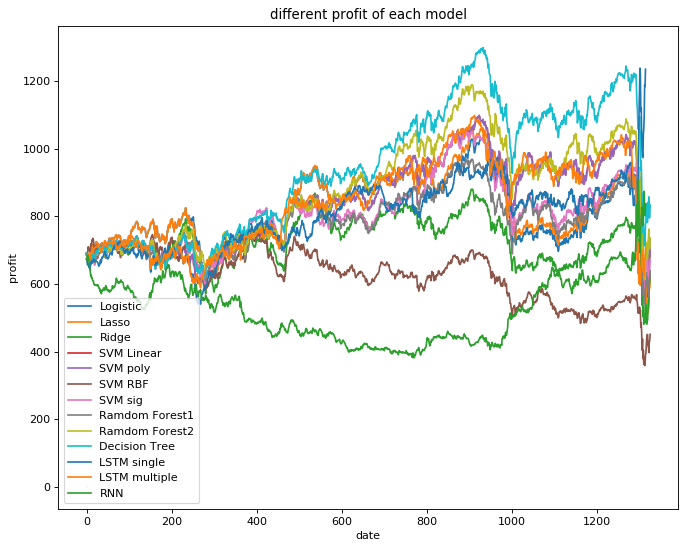

In [646]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(log_port2, label='Logistic')
plt.plot(lasso_port, label='Lasso')
plt.plot(ridge_port, label='Ridge')
plt.plot(svmlinear_port,label='SVM Linear')
plt.plot(svmpoly_port,label='SVM poly')
plt.plot(svmrbf_port1,label='SVM RBF')
plt.plot(svmsig_port2, label='SVM sig')
plt.plot(forest_port, label='Ramdom Forest1')
plt.plot(forest2_port, label='Ramdom Forest2')
plt.plot(tree_port, label='Decision Tree')
plt.plot(single_port1, label='LSTM single')
plt.plot(multiple_port, label='LSTM multiple')
plt.plot(rnn_port, label='RNN')
plt.xlabel('date')
plt.ylabel('profit')
plt.title('different profit of each model')
plt.legend(loc='best')
plt.show()